In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.parse
import requests
from bs4 import BeautifulSoup
import pickle

In [ ]:
# open PoetryData.csv
poetry_data = pd.read_csv('PoetryData.csv')
poetry_data.head()

# go through the data and trim the whitespace from the beginning and end of each string in the DataFrame
poetry_data = poetry_data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

poetry_data.head()

# save as PoetryDataTrimmed.csv
poetry_data.to_csv('PoetryDataTrimmed.csv', index=False) # save the trimmed data to a new CSV file

In [620]:
# open PoetData.csv
poet_data = pd.read_csv('PoetData.csv')
# sort by Birth Year
poet_data = poet_data.sort_values(by='Birth Year')

# add an Order column based on the order of the Birth Year
poet_data['Order'] = np.arange(len(poet_data))

poet_data.head()

,Poet,Birth Year,Death Year,Order
12,Geoffrey Chaucer,1343,1400.0,0
10,Elizabeth Barrett Browning,1806,1861.0,1
16,Walt Whitman,1819,1892.0,2
14,Emily Dickinson,1830,1886.0,3
11,William Butler Yeats,1865,1939.0,4


In [622]:
# create a dictionary with Order as key and Birth Year as value
year_order_dict = dict(zip(poet_data['Order'], poet_data['Birth Year']))

In [ ]:
# check if poet_data['name'] is in poetry_data['poet'] if if not print the name
for name in poet_data['Poet']:
    if name not in poetry_data['Poet'].values:
        print(name)

In [ ]:
# filter PoetryData to only include poems whose poets are in PoetData
poetry_data_filtered = poetry_data[poetry_data['Poet'].isin(poet_data['Poet'])]

# save the filtered data to a new CSV file
poetry_data_filtered.to_csv('PoetryDataFiltered.csv', index=False)

In [ ]:
# add Poet Birth Year and Death Year to PoetryDataFiltered.csv
poetry_data_filtered = poetry_data_filtered.merge(poet_data[['Poet', 'Birth Year', 'Death Year', 'Order']], on='Poet', how='left')

# if Death Year is NaN, set it to 2025
poetry_data_filtered['Death Year'] = poetry_data_filtered['Death Year'].fillna(2025)

# save the filtered data to a new CSV file
poetry_data_filtered.to_csv('PoetryDataYears.csv', index=False) # save the trimmed data to a new CSV file

In [2]:
# open PoetryDataYears.csv
poetry_data_years = pd.read_csv('PoetryDataYears.csv')
poetry_data_years.head()

,Unnamed: 0,Title,Poem,Poet,Tags,Birth Year,Death Year,Order
0,2,Look for Me,Look for me under the hood\r\r\nof that old Ch...,Ted Kooser,NaN,1939,2025.0,30
1,3,Wild Life,"Behind the silo, the Mother Rabbit\r\r\nhunche...",Grace Cavalieri,NaN,1935,2025.0,25
2,4,Umbrella,When I push your button\r\r\nyou fly off the h...,Connie Wanek,NaN,1952,2025.0,37
3,6,Invisible Fish,Invisible fish swim this ghost ocean now descr...,Joy Harjo,"Living,Time & Brevity,Relationships,Family & A...",1951,2025.0,35
4,7,Don’t Bother the Earth Spirit,Don’t bother the earth spirit who lives here. ...,Joy Harjo,"Religion,The Spiritual,Mythology & Folklore,Fa...",1951,2025.0,35


In [ ]:
# remove poems shorter than 10 characters
poetry_data_years = poetry_data_years[poetry_data_years['Poem'].str.len() > 10]

In [629]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim import corpora, models
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
# Ensure necessary NLTK data is downloaded
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')

In [631]:
def extract_themes(poem):
    try:
        # Initialize sentiment analyzer
        sia = SentimentIntensityAnalyzer()
        
        # Tokenize the poem
        tokens = nltk.word_tokenize(poem)
        
        # Remove stopwords and lemmatize tokens
        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()
        filtered_tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens if token.isalpha() and token.lower() not in stop_words]
        
        # Sentiment analysis
        sentiment = sia.polarity_scores(poem)
        
        # Topic modeling (simplified for a single poem)
        dictionary = corpora.Dictionary([filtered_tokens])
        corpus = [dictionary.doc2bow(filtered_tokens)]
        lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, passes=1, num_topics=1)
        
        # Print topics (simplified output)
        topics = lda_model.print_topics()
        themes = []
        if topics:
            topic_words = topics[0][1].split('+')
            for word in topic_words:
                word = word.strip().split('*')[1].strip('"')
                themes.append(word)

        return themes, sentiment
    except Exception as e:
        print(f"Error processing {poem}: {e}")

In [ ]:
# add themes and sentiment to poetry_data_years
poetry_data_years['Themes'] = poetry_data_years['Poem'].apply(lambda x: extract_themes(x)[0])
poetry_data_years['Sentiment'] = poetry_data_years['Poem'].apply(lambda x: extract_themes(x)[1])

In [ ]:
# convert death year to int
poetry_data_years['Death Year'] = poetry_data_years['Death Year'].astype(int)
poetry_data_years.head()

In [ ]:
# save the data to a new CSV file PoetryDataThemesSentiment.csv
poetry_data_years.to_csv('PoetryDataThemesSentiment.csv', index=False) # save to CSV file

In [10]:
poetry_data_themes_sentiment = pd.read_csv('PoetryDataThemesSentiment.csv')

In [ ]:
# convert themes from string to list
poetry_data_themes_sentiment['Themes'] = poetry_data_themes_sentiment['Themes'].apply(lambda x: eval(x))

# convert sentiment from string to dict
poetry_data_themes_sentiment['Sentiment'] = poetry_data_themes_sentiment['Sentiment'].apply(lambda x: eval(x))

poetry_data_themes_sentiment.head()

In [ ]:
# open PoetryDataThemesSentiment.csv
poetry_data_themes_sentiment = pd.read_csv('PoetryDataThemesSentiment.csv')
poetry_data_themes_sentiment.head()


In [ ]:
# make sentiment the compound score
for index, row in poetry_data_themes_sentiment.iterrows():
    sentiment = eval(row['Sentiment'])
    poetry_data_themes_sentiment.at[index, 'Sentiment'] = sentiment['compound']

poetry_data_themes_sentiment.head()

,Unnamed: 0,Title,Poem,Poet,Tags,Birth Year,Death Year,Order,Themes,Sentiment
0,2,Look for Me,Look for me under the hood\r\r\nof that old Ch...,Ted Kooser,NaN,1939,2025.0,30,"['engine', 'leaked', 'look', 'weed', 'know', '...",-0.9091
1,3,Wild Life,"Behind the silo, the Mother Rabbit\r\r\nhunche...",Grace Cavalieri,NaN,1935,2025.0,25,"['one', 'behind', 'could', 'would', 'mother', ...",0.7278
2,4,Umbrella,When I push your button\r\r\nyou fly off the h...,Connie Wanek,NaN,1952,2025.0,37,"['old', 'something', 'sometimes', 'vulnerable'...",-0.8146
3,6,Invisible Fish,Invisible fish swim this ghost ocean now descr...,Joy Harjo,"Living,Time & Brevity,Relationships,Family & A...",1951,2025.0,35,"['ocean', 'fish', 'later', 'much', 'paint', 'g...",0.0194
4,7,Don’t Bother the Earth Spirit,Don’t bother the earth spirit who lives here. ...,Joy Harjo,"Religion,The Spiritual,Mythology & Folklore,Fa...",1951,2025.0,35,"['story', 'see', 'beauty', 'stone', 'blinding'...",0.9354


In [11]:
# get all themes in the data and create a dict where keys are themes and values are poems with that theme
themes_dict = {}
for index, row in poetry_data_themes_sentiment.iterrows():
    for theme in eval(row['Themes'])[:10]:
        if theme not in themes_dict:
            themes_dict[theme] = []
        themes_dict[theme].append(row['Title'])

# print the number of keys
print(len(themes_dict))

2666


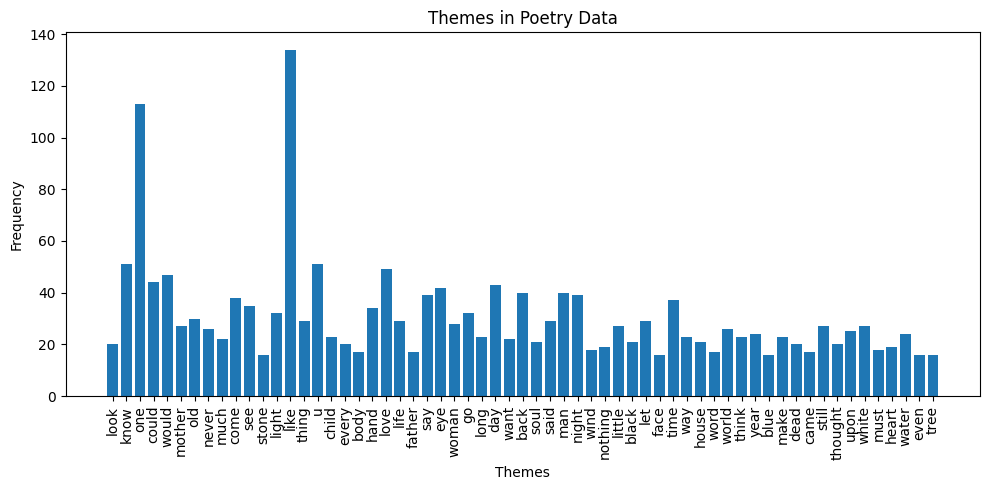

In [641]:
# graph frequency of keys
themes_freq = {k: len(v) for k, v in themes_dict.items()}
# remove themes with less than 10 poems
themes_freq = {k: v for k, v in themes_freq.items() if v > 15}
# plot the top 10 themes
plt.figure(figsize=(10, 5))
plt.bar(themes_freq.keys(), themes_freq.values())
plt.xticks(rotation=90)
plt.title('Themes in Poetry Data')
plt.xlabel('Themes')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [642]:
import networkx as nx

In [643]:
# create a graph where each node is a poem and an edge is formed if two poems share a common theme and the Order column is 1 apart

# create a graph
G = nx.Graph()

# add nodes
for index, row in poetry_data_themes_sentiment.iterrows():
    G.add_node(row['Title'], poet=row['Poet'], year=row['Birth Year'], order=row['Order'], themes=eval(row['Themes']), sentiment=row['Sentiment'])

edge_labels = {}

# add edges
for theme, poems in themes_dict.items():
    for i in range(len(poems)):
        for j in range(i + 1, len(poems)):
            order1 = poetry_data_themes_sentiment[poetry_data_themes_sentiment['Title'] == poems[i]]['Order'].values[0]
            order2 = poetry_data_themes_sentiment[poetry_data_themes_sentiment['Title'] == poems[j]]['Order'].values[0]

            year1 = poetry_data_themes_sentiment[poetry_data_themes_sentiment['Title'] == poems[i]]['Birth Year'].values[0]
            year2 = poetry_data_themes_sentiment[poetry_data_themes_sentiment['Title'] == poems[j]]['Birth Year'].values[0]

            if year_order_dict.get(order1 + 1) == year2 or year_order_dict.get(order2 + 1) == year1:
                G.add_edge(poems[i], poems[j], theme=theme)

            # add edge labels with key as sorted tuple of the two poems and value as theme
            edge_labels[tuple(sorted([poems[i], poems[j]]))] = theme

In [644]:
# save graph object to file
# pickle.dump(G, open('graph.pickle', 'wb'))

# load graph object from file
G = pickle.load(open('graph.pickle', 'rb'))

In [645]:
# only keep the biggest connected component
largest_cc = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_cc).copy()

In [ ]:
# create initial positions with y coordinate proportional to birth year
pos = {}
for node in G.nodes():
    year = G.nodes[node]['year']
    order = G.nodes[node]['order']
    # let x coordinate be random
    x_pos = np.random.rand() * 10
    y_pos = order*3 + np.random.rand() * 5
    pos[node] = (x_pos, y_pos)

# print(pos)
# pos = None

In [648]:
# randomly choose one of the first 5 nodes and one of the last 5 nodes
beginning = np.random.choice(sorted(G.nodes(), key=lambda n: G.nodes[n]['order'])[:5])  # first 5 nodes by order
end = np.random.choice(sorted(G.nodes(), key=lambda n: G.nodes[n]['order'], reverse=True)[:5])  # last 5 nodes by order

# set x coords of beginning and end to 0 and fix them
pos[beginning] = (0, pos[beginning][1])  # set x of beginning to 0
pos[end] = (10, pos[end][1])  # set x of end to 10

In [649]:
# visualize
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, pos=pos, fixed=[beginning, end], k=0.4)  # positions for all nodes
# nx.draw(G, pos, node_size=20, node_color='lightblue', edge_color='gray')
# plt.title('Poem Network Graph')
# plt.show()

<Figure size 1200x1200 with 0 Axes>

In [650]:
import plotly.graph_objects as go

In [6]:
from transformers import BertTokenizer, BertModel
import torch
from sklearn.cluster import KMeans

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(words):
    inputs = tokenizer(words, return_tensors='pt', padding=True)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :]  # Use the CLS token embeddings
    return embeddings.detach().numpy()

def get_clusters(words, embeddings, n_clusters=10, n_init=30):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init).fit(embeddings)

    # Create a dictionary to hold the clusters
    clusters = {i: [] for i in range(n_clusters)}
    for i, label in enumerate(kmeans.labels_):
        clusters[label].append(words[i])

    return clusters

In [12]:
# get list of all themes
themes = list(themes_dict.keys())

# embeddings = get_bert_embeddings(themes)

# download embeddings
# with open('embeddings.pkl', 'wb') as f:
#     pickle.dump(embeddings, f)

In [13]:
# open embeddings.pkl
with open('embeddings.pkl', 'rb') as f:
    embeddings = pickle.load(f)

In [14]:
# cluster the themes
theme_clusters = get_clusters(themes, embeddings, n_clusters=8, n_init=25)

# print the clusters
# for cluster, words in theme_clusters.items():
#     print(f"Cluster {cluster}: {words}")

In [15]:
def get_summary_word(words_to_summarize):
    with open('embeddings.pkl', 'rb') as f:
        word_vectors = pickle.load(f)

    # combine themes and word_vectors into a dict
    vectors_dict = dict(zip(themes, word_vectors))

    # Compute the average vector
    average_vector = sum(vectors_dict[word] for word in words_to_summarize) / len(words_to_summarize)

    # if "sadie" in words to summarize, remove it from the list
    words_to_summarize = [word for word in words_to_summarize if word.lower() not in ["sadie", "olive", "hump"]]

    # Find the most similar word to the average vector from pretrained bert model
    similarities = {word: np.dot(vectors_dict[word], average_vector) for word in words_to_summarize}
    summary_word = max(similarities, key=similarities.get)

    return summary_word

In [16]:
# change keys to summary words
summary_theme_clusters = {}

for cluster, words in theme_clusters.items():
    summary_word = get_summary_word(words)
    if summary_word in summary_theme_clusters:
        summary_theme_clusters[summary_word] += words
    else:
        summary_theme_clusters[summary_word] = words

# print the clusters
for cluster, words in summary_theme_clusters.items():
    print(f"{cluster}: {words[:10]}")

seek: ['know', 'one', 'fly', 'end', 'much', 'u', 'feel', 'every', 'father', 'proof']
eve: ['weed', 'forward', 'forgotten', 'moth', 'behind', 'could', 'would', 'beneath', 'rabbit', 'writing']
pea: ['engine', 'look', 'settled', 'mother', 'something', 'carried', 'store', 'story', 'central', 'weight']
lover: ['leaked', 'silo', 'advocacy', 'fish', 'paint', 'earth', 'orchard', 'child', 'body', 'apple']
impulsively: ['hydrangea', 'petal', 'loader', 'pomegranate', 'shopped', 'strenuous', 'skilful', 'scraggy', 'pomp', 'byzantium']
home: ['vulnerable', 'ocean', 'country', 'gold', 'sailboat', 'yellow', 'green', 'extortionary', 'human', 'live']
loneliness: ['shoving', 'strength', 'ghost', 'dream', 'come', 'small', 'wholly', 'love', 'life', 'squeaky']
appeared: ['become', 'remembers', 'lived', 'hear', 'two', 'inch', 'speak', 'mended', 'repeated', 'confess']


In [658]:
# create a dict with keys as themes and values as summary words
themes_summary_dict = {}
for cluster, words in summary_theme_clusters.items():
    for word in words:
        themes_summary_dict[word] = cluster

In [ ]:
sentiments = [G.nodes[node]['sentiment'] for node in G.nodes()]

# map each node's theme to its summary word and assign colors based on clusters
clusters = list(set(themes_summary_dict.values()))
colors = plt.cm.tab20b(np.linspace(0, 1, len(clusters)))  
cluster_color_map = {
    cluster: f'rgb({int(c[0]*255)},{int(c[1]*255)},{int(c[2]*255)})'
    for cluster, c in zip(clusters, colors)
}

# Extract edge and node coordinates
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

node_x = [pos[node][0] for node in G.nodes()]
node_y = [pos[node][1] for node in G.nodes()]

# Create edge trace
edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=2, color='#888'),  # Fallback color
    hoverinfo='none',
    mode='lines',
    showlegend=False
)

hover_traces = []
for edge in G.edges():
    sorted_edge = tuple(sorted(edge))
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    
    # Get edge label and cluster
    edge_label = edge_labels[sorted_edge]  
    cluster = themes_summary_dict[edge_label]
    edge_color = cluster_color_map[cluster]

    # Create segmented edge trace
    num_segments = 10
    x_vals = [x0 + (x1-x0)*i/num_segments for i in range(num_segments+1)]
    y_vals = [y0 + (y1-y0)*i/num_segments for i in range(num_segments+1)]
    
    trace = go.Scatter(
    x=x_vals,
    y=y_vals,
    mode='lines',
    line=dict(width=2, color=edge_color),
    hoverinfo='text',
    text=[edge_label] * (num_segments+1),
    hoverlabel=dict(
        bgcolor=edge_color,  # Match edge color
        font_size=12,
        font_family="Arial",
        font_color='white'  
    ),
    showlegend=False
    )
    hover_traces.append(trace)

# Create node trace
node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='RdYlGn',
        size=10,
        color=sentiments,
        cmin=-1,
        cmax=1,
        colorbar=dict(
            title=dict(text='Sentiment'),
            thickness=15,
            tickvals=[-1, 0, 1],
            ticktext=['Negative', 'Neutral', 'Positive']
        )
    ),
    hoverlabel=dict(
        bgcolor='white',  # Fixed background color
        font=dict(
            size=12,
            family="Arial",
            color='black'  # Fixed text color for better readability
        )
    ),
    showlegend=False
)

# Add node information
node_adjacencies = []
node_text = []

# add author and birth year to node text
for node in G.nodes():
    node_adjacencies.append(len(list(G.neighbors(node))))
    node_info = f"{node}<br>Poet: {G.nodes[node]['poet']}<br>Birth Year: {G.nodes[node]['year']}<br>Sentiment: {G.nodes[node]['sentiment']}"
    node_text.append(node_info)

node_trace.marker.color = sentiments
node_trace.text = node_text

node_trace.marker.colorbar.update(
    x=1.05,  # Move colorbar further right
    y=0.5,   # Center vertically
    len=0.5  # Reduce height 
)

legend_traces = []
for cluster, color in cluster_color_map.items():
    legend_traces.append(
        go.Scatter(
            x=[None], y=[None],
            mode='lines',
            line=dict(color=color, width=4),
            name=cluster
        )
    )

fig = go.Figure(
    data=[edge_trace, *hover_traces, node_trace, *legend_traces],
    layout=go.Layout(
        showlegend=True,  # Enable legend
        hovermode='closest',
        margin=dict(b=0, l=0, r=0, t=0),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
)

fig.update_layout(
    title_text="The Evolution of Key Words in Poetry",  # Add title
    title_x=0.5,  # Center the title horizontally
    title_y=0.95,  # Adjust vertical position (optional)
    title_font=dict(size=24, family='Arial'),  # Customize font size and style
    legend=dict(
        x=-0.25,
        y=0.5,
        xanchor='left',
        yanchor='middle',
        bgcolor='rgba(255,255,255,0.9)'
    ),
    margin=dict(
        l=150,
        r=150,
        t=70  # Increase top margin to prevent cutoff
    )
)

# Enable zoom
config = {'scrollZoom': True}
fig.show(config=config)

In [663]:
fig.write_html("graph.html")